In [18]:
import numpy as np 
import matplotlib.pyplot as plt
import random as random
%matplotlib inline
from casadi import *


Ici on va résoudre un problème optimal inverse qui est representer comme un problème optimal a deux niveaux. 

Notre problème est : 

 $$(1) \ \ min_{ \alpha} \sum_{i=1}^{m} \left\| z^{*}(t_{j},\alpha) - z_{M}(t_{j}) \right\|    \\ $$
où $z^{*}(t,\alpha)$ solution de  (2)

$$ \updownarrow $$

 \begin{align*}
(2)  \ \ min_{X,u} \ &   \alpha_{0} T + \alpha_{1} \int_{0}^{T}u_{1}^2 dt + \alpha_{2} \int_{0}^{T}u_{2}^2 dt + \alpha_{3} \int_{0}^{T}u_{3}^2 dt    \\
s.c \ & \dot{x} = cos(\theta)v_{avant} - sin(\theta)v_{orth} \\
& \dot{y} = sin(\theta)v_{avant} + cos(\theta)v_{orth}  \\
& \dot{\theta} = w  \\
& \dot{v}_{avant} = u_1  \\
& \dot{w} = u_2  \\
& \dot{v}_{orth} = u_3  \\
& X(0) = X_0  \ \ et \ \  X(T) = X_{final}
\end{align*}

#### Notation :
$ \Delta t = \frac{T}{n}  $

$ x[i]  : = x(i \Delta t )   \ \forall i \in \{1,...,n \} $   

#### Remarque : 
Notre intégrale on va l'approché par la méthode des triangles.

Prenons une subdivision de notre interval [0,T] en N sous intervalle. Nous allons transformer notre problème continue en un problème discret et de plus on va transformer nos équations diférentielle prenons par exemple $ \frac{x[i+1]+x[i]}{\Delta t} $  qui est une approximation de $ \dot{x}[i]  \ \ (donc \ \ \dot{x}[i] := \frac{x[i+1]+x[i]}{\Delta t} $  Formule de Taylor)


\begin{align*}
(2)  \ \  \ min_{X(i),u(i)} \ &   \Delta t  \sum_{i=1}^{n} ( \alpha_{0} + \alpha_{1} u_{1}^2[i]+ \alpha_{2} u_{2}^2[i] + \alpha_{3}u_{3}^2[i]  )   \\
s.c \ &  \forall i \in \{1,...,n \}  \\
& x[i+1] = x[i] + \Delta t(cos(\theta[i])v_{avant}[i] - sin(\theta[i])v_{orth}[i]) \\
& y[i+1] = y[i] + \Delta t(sin(\theta[i])v_{avant}[i] + cos(\theta[i])v_{orth}[i])  \\
& \theta[i+1] = \theta[i] + \Delta t (w[i])  \\
& v_{avant}[i+1] = v_{avant}[i] + \Delta t (u_1[i])  \\
& w[i+1] = w[i] + \Delta t (u_2[i])  \\
& v_{orth}[i+1] = v_{orth}[i] + \Delta t (u_3[i])  \\
& X[0] = X_0  \ \ et \ \  X[T] = X_{final}
\end{align*}

Pour résoudre le problème (1), dans l'article ils ont utilisé la méthode d'optimisation sans dérivées BOBYQA.

Pour résoudre le problème (2), ils ont utilisé la méthode MUSCOD, un problème de la valeur limite directe.

Soit $ \Delta t = \frac{T}{n}  $
\begin{align*}
(2)  \ \  \ min_{X(i),u(i)} \ &   \Delta t  \sum_{i=1}^{n} ( \alpha_{0} + \alpha_{1} u_{1}^2[i]+ \alpha_{2} u_{2}^2[i] + \alpha_{3}u_{3}^2[i]  )   \\
s.c \ &  \forall i \in \{1,...,n \}  \\
& x[i+1] = x[i] + \Delta t(cos(\theta[i])v_{avant}[i] - sin(\theta[i])v_{orth}[i]) \\
& y[i+1] = y[i] + \Delta t(sin(\theta[i])v_{avant}[i] + cos(\theta[i])v_{orth}[i])  \\
& \theta[i+1] = \theta[i] + \Delta t (w[i])  \\
& v_{avant}[i+1] = v_{avant}[i] + \Delta t (u_1[i])  \\
& w[i+1] = w[i] + \Delta t (u_2[i])  \\
& v_{orth}[i+1] = v_{orth}[i] + \Delta t (u_3[i])  \\
& X[0] = X_0  \ \ et \ \  X[T] = X_{final}
\end{align*}

Essayons de résoudre (2) indépendement de (1) 

In [161]:
n = 100
T = 2.5
taux = T/n

Times = np.linspace(0, T, n)

In [162]:
## selon le rapport

alfa0 = 1
alfa1 = 1.139
alfa2 = 0.159
alfa3 = 2.681

In [172]:
x0 = 0
y0 = 0
teta0 = 90

xf = 0.5
yf = 0
tetaf = 91

In [173]:
## variable de position
x = SX.sym('x', n )
y = SX.sym('y', n )
teta = SX.sym('teta', n )

## variable de vitesse 
v1 = SX.sym('v1', n )
v2 = SX.sym('v2', n )
w = SX.sym('w', n )

## variable des accélérations 
u1 = SX.sym('u1', n )         ## accélération de v1 
u2 = SX.sym('u2', n )         ## accélération angulaire 
u3 = SX.sym('u3', n )         ## accélération de v2

#### Fonctions utile

In [174]:
f= Function('f',[x],[x[1:]])

In [175]:
phi = Function ('phi', [u1,u2,u3], [(taux)*(alfa0+ alfa1*dot(u1,u1)+alfa2*dot(u2,u2)+ alfa3*dot(u3,u3))]) 

In [176]:
opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

## les positions
x = opti.variable(n)
y = opti.variable(n)
teta = opti.variable(n)

## les vitesses 
v1 = opti.variable(n)
v2 = opti.variable(n)
w = opti.variable(n)

## les accélération
u1 = opti.variable(n)
u2 = opti.variable(n)
u3 = opti.variable(n)


In [177]:
opti.minimize( (taux)*(alfa0+ alfa1*dot(u1,u1)+alfa2*dot(u2,u2)+ alfa3*dot(u3,u3)) )    # ma fonction objetion

# mes fonctions de contrainte d'égalité:

## pour les condition initial
opti.subject_to( x[0] == x0)        
opti.subject_to( y[0] == y0)
opti.subject_to( teta[0] == teta0)

## pour les contraintes d'égaliter
opti.subject_to( f(x) == x[:n-1]+taux*(cos(teta[:n-1])*v1[:n-1] - sin(teta[:n-1])*v2[:n-1]) )
opti.subject_to( f(y) == y[:n-1]+taux*(sin(teta[:n-1])*v1[:n-1] + cos(teta[:n-1])*v2[:n-1]) )
opti.subject_to( f(teta) == teta[:n-1] + taux*w[:n-1] )
opti.subject_to( f(v1) == v1[:n-1]+taux*u1[:n-1] )
opti.subject_to( f(w) == w[:n-1] + taux*u2[:n-1] )
opti.subject_to( f(v2) == v2[:n-1]+taux*u3[:n-1] )

## pour les conditions finales
opti.subject_to( x[-1]==xf)
opti.subject_to( y[-1]==yf)
opti.subject_to( teta[-1]==tetaf)


opti.solver('ipopt')      # suivant la méthode de KKT


sol = opti.solve()


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     2184
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      597

Total number of variables............................:      900
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5000000e-02 9.10e+01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [178]:
X = sol.value(x)
Y = sol.value(y)
U1 = sol.value(u1)
U2 = sol.value(u2)
U3 = sol.value(u3)

#sol.value(teta)

In [179]:
F = np.zeros(n)

for i in range (n):
    F[i] = phi(U1[i], U2[i], U3[i])

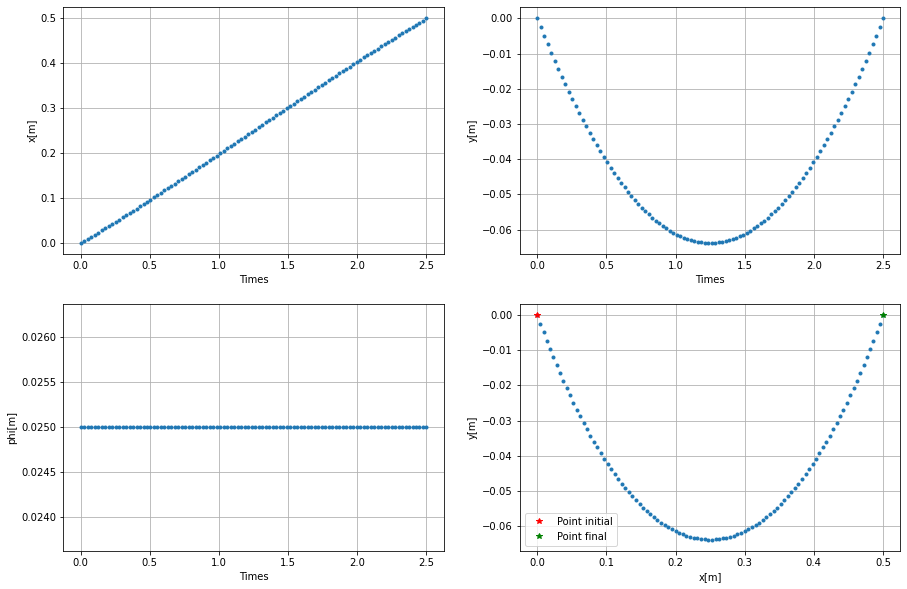

In [180]:
plt.subplots(figsize=(15, 10))

plt.subplot(2, 2, 1) 
plt.plot (Times,X , '.')
plt.xlabel('Times')
plt.ylabel('x[m]')
plt.grid(True)

plt.subplot(2, 2, 2) 
plt.plot (Times,Y , '.')
plt.xlabel('Times')
plt.ylabel('y[m]')
plt.grid(True)

plt.subplot(2, 2, 3) 
plt.plot (Times,F , '.')
plt.xlabel('Times')
plt.ylabel('phi[m]')
plt.grid(True)

plt.subplot(2, 2, 4) 
plt.plot (X,Y , '.')
plt.plot(x0,y0, '*', label = 'Point initial', color = 'red')
plt.plot(xf,yf, '*', label = 'Point final', color = 'green')

plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.grid(True)
plt.legend()